This is our recreation of Lehtinen et al.'s paper "Noise2Noise". 

## Google Colab setup

In [60]:
# from google.colab import drive
# drive.mount('/content/drive')

## Imports

In [61]:
import numpy as np
import cv2
import tensorflow as tf
import keras
import matplotlib.pyplot as plt
from importlib import reload

In [62]:
from helpers import generators, utils, noise_models
from models import unet_n2n, irfan_2020

In [77]:
reload(utils)
reload(noise_models)

<module 'helpers.noise_models' from '/Users/antrikshdhand/Documents/github/thesis-ml/ml/main/helpers/noise_models.py'>

## Initialise data

In [64]:
# TRAIN_IMAGE_DIR = "drive/MyDrive/imagenet-10k"
TRAIN_IMAGE_DIR = "../../raw_datasets/imagenet-10k"
# VAL_IMAGE_DIR = "drive/MyDrive/BSDS300/images/train"
VAL_IMAGE_DIR = "../../raw_datasets/BSDS300/images/train"
# TEST_IMAGE_DIR = "drive/MyDrive/BSDS300/images/test"
TEST_IMAGE_DIR = "../../raw_datasets/BSDS300/images/test"

NUM_EPOCHS = 50
GPU_BATCH_SIZE = 4
DATA_BATCH_SIZE = 16

In [65]:
noise_model = noise_models.gaussian_noise

In [66]:
training_gen = generators.NoisyImageTrainGenerator(
    image_dir=TRAIN_IMAGE_DIR,
    input_noise_model=noise_model,
    target_noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

validation_gen = generators.NoisyImageValGenerator(
    image_dir=VAL_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

test_gen = generators.NoisyImageValGenerator(
    image_dir=TEST_IMAGE_DIR,
    noise_model=noise_model,
    batch_size=DATA_BATCH_SIZE,
    patch_edge_size=192,
    zero_one_normalisation=True,
    greyscale=True
)

## Initialise model

In [67]:
def psnr(y_true, y_pred):
    return tf.image.psnr(y_true, y_pred, max_val=1.0)

In [68]:
model = irfan_2020.get_irfan_model(input_shape=(192, 192, 1))
# model = unet_n2n.get_unet_model(input_shape=(192, 192, 1))

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-5, beta_1=0.9, beta_2=0.99, epsilon=1e-8),
    loss=keras.losses.MeanSquaredError(),
    metrics=[psnr],
)

model.summary()

Model: "irfan_2020"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 192, 192, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 192, 192, 64)      640       
                                                                 
 activation (Activation)     (None, 192, 192, 64)      0         
                                                                 
 batch_normalization (Batch  (None, 192, 192, 64)      256       
 Normalization)                                                  
                                                                 
 max_pooling2d (MaxPooling2  (None, 96, 96, 64)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 96, 96, 64)        3

## Train model

In [69]:
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    # filepath="drive/MyDrive/saved_models/n2n_imagenet_unet/{epoch:02d}.keras",
    filepath="models/saved/n2n_imagenet10k_05122024/irfan/{epoch:02d}.keras",
    monitor='val_psnr',
    mode='max',
    save_best_only=True
)

csv_logger = keras.callbacks.CSVLogger(
    # filename='drive/MyDrive/saved_models/n2n_imagenet_unet/training.log',
    filename="models/saved/n2n_imagenet10k_05122024/irfan/training.log",
    separator=',',
    append=False
)

backup_callback = keras.callbacks.BackupAndRestore(
    # backup_dir="drive/MyDrive/saved_models/n2n_imagenet_unet"
    backup_dir="models/saved/n2n_imagenet10k_05122024/irfan/tmp"
)

In [70]:
history = model.fit(
    training_gen,
    validation_data=validation_gen,
    batch_size=GPU_BATCH_SIZE,
    epochs=NUM_EPOCHS,
    verbose=2,
    callbacks=[csv_logger, backup_callback]
)

Epoch 1/50


2024-12-05 20:50:46.389174: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-12-05 20:53:12.843872: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


625/625 - 148s - loss: 0.0345 - psnr: 15.0342 - val_loss: 0.0181 - val_psnr: 17.8468 - 148s/epoch - 237ms/step
Epoch 2/50
625/625 - 147s - loss: 0.0260 - psnr: 16.1150 - val_loss: 0.0129 - val_psnr: 19.9324 - 147s/epoch - 235ms/step
Epoch 3/50
625/625 - 148s - loss: 0.0244 - psnr: 16.3947 - val_loss: 0.0113 - val_psnr: 20.4878 - 148s/epoch - 236ms/step
Epoch 4/50
625/625 - 149s - loss: 0.0236 - psnr: 16.5392 - val_loss: 0.0104 - val_psnr: 20.7838 - 149s/epoch - 238ms/step
Epoch 5/50
625/625 - 149s - loss: 0.0232 - psnr: 16.6345 - val_loss: 0.0107 - val_psnr: 20.9251 - 149s/epoch - 238ms/step
Epoch 6/50
625/625 - 149s - loss: 0.0228 - psnr: 16.7006 - val_loss: 0.0103 - val_psnr: 20.9910 - 149s/epoch - 238ms/step
Epoch 7/50
625/625 - 149s - loss: 0.0224 - psnr: 16.7729 - val_loss: 0.0095 - val_psnr: 21.1327 - 149s/epoch - 238ms/step
Epoch 8/50
625/625 - 149s - loss: 0.0221 - psnr: 16.8375 - val_loss: 0.0104 - val_psnr: 20.8024 - 149s/epoch - 238ms/step
Epoch 9/50
625/625 - 149s - loss: 0

In [ ]:
model.save("models/saved/n2n_imagenet10k_05122024/irfan/irfan_50epochs.keras")

/var/folders/6d/6rll4yfx64n5s_34fjy87zd80000gn/T/ipykernel_74785/953817949.py:11: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  together.show()


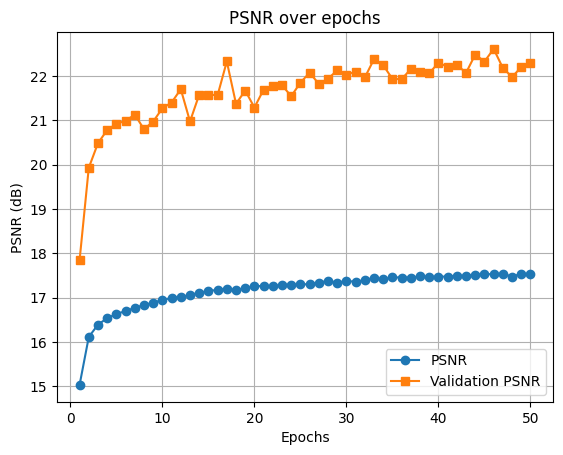

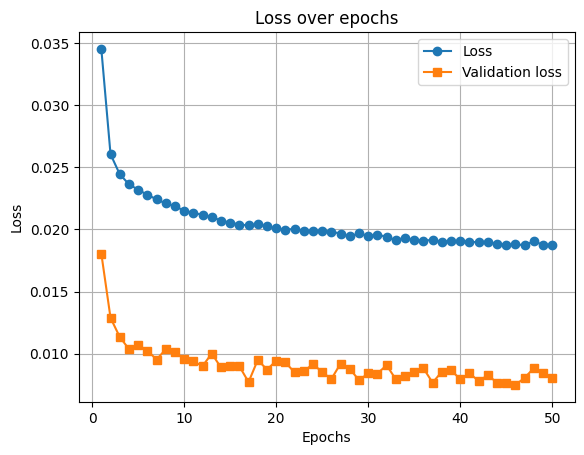

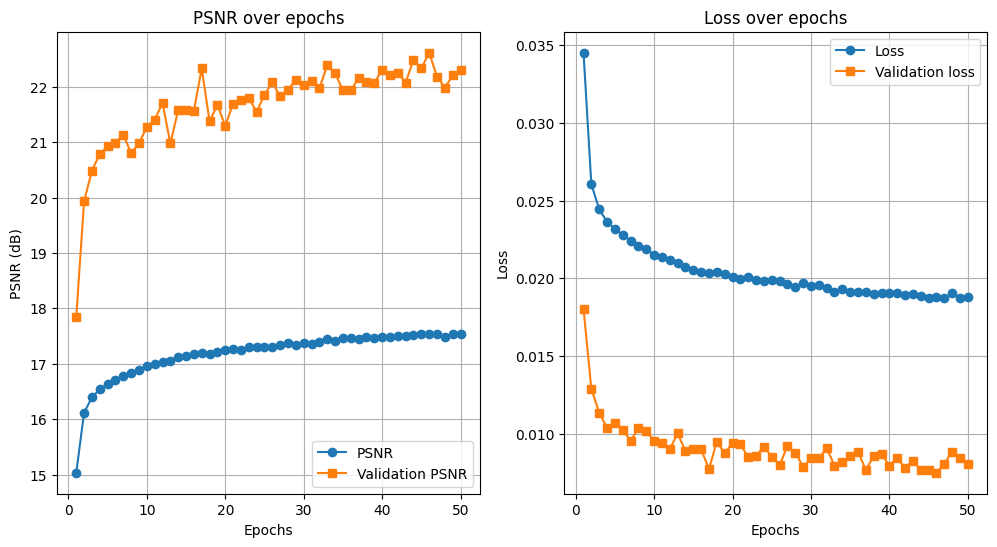

In [ ]:
reload(utils)

fig_psnr, fig_loss = utils.get_psnr_and_loss_curves(history, together=False)
fig_psnr.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/psnr.pdf')
fig_loss.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/loss.pdf')
fig_psnr.show()
fig_loss.show()

together = utils.get_psnr_and_loss_curves(history, together=True)
together.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/psnr_loss.pdf')
together.show()


## Evaluate model

In [73]:
evals = model.evaluate(
    test_gen,
    batch_size=GPU_BATCH_SIZE,
    verbose=2
)

6/6 - 0s - loss: 0.0092 - psnr: 21.6035 - 297ms/epoch - 49ms/step


In [74]:
evals

[0.009226801805198193, 21.603548049926758]

In [100]:
# reload(utils)

# ground_truth_fig, patches_fig = utils.test_model_on_image(
#     image_path=TEST_IMAGE_DIR + "/285079.jpg", 
#     model=model,
#     patch_size=192, 
#     zero_one_normalisation=True, 
#     greyscale=True,
#     stddev=30
# )

# ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/ground_truth_fig_1.pdf')
# patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/patches_fig_1.pdf')

1/1 [==============================] - 0s 84ms/step


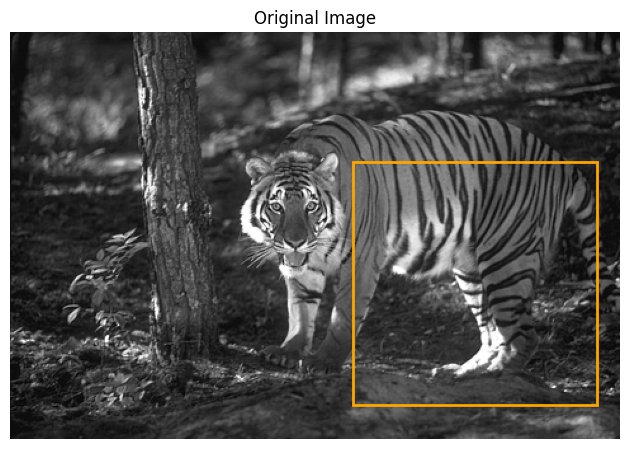

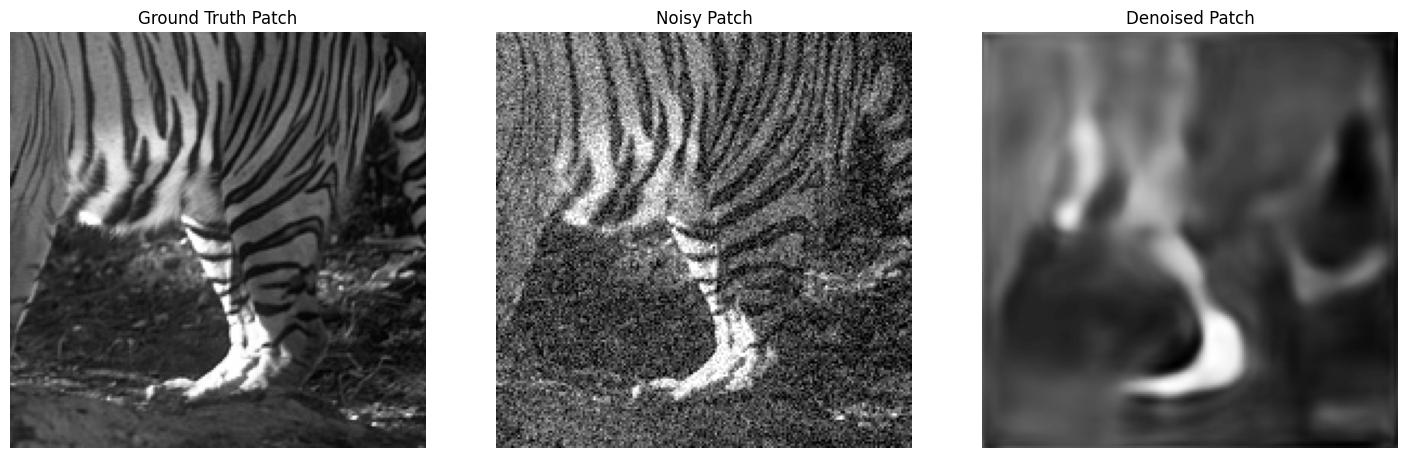

In [99]:
reload(utils)

ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/108005.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30
)

ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/ground_truth_fig_2.pdf')
patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/patches_fig_2.pdf')

1/1 [==============================] - 0s 38ms/step


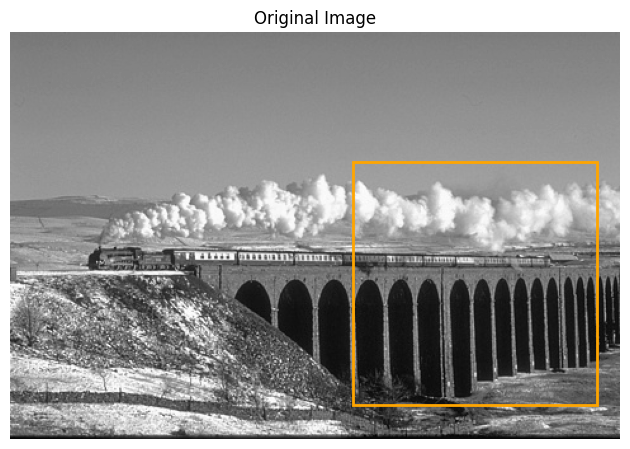

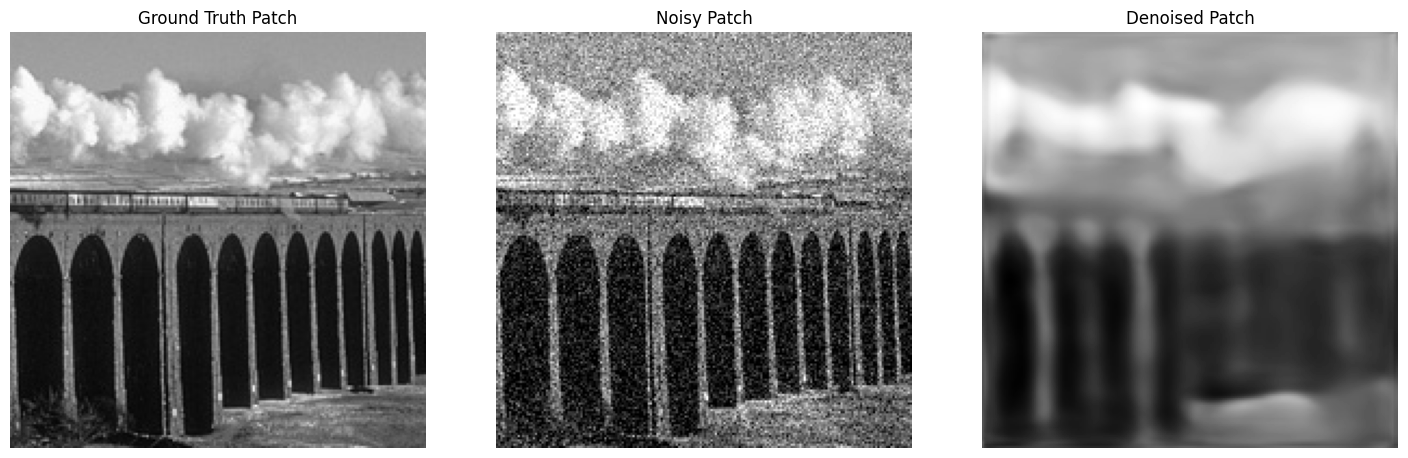

In [98]:
reload(utils)

ground_truth_fig, patches_fig = utils.test_model_on_image(
    image_path=TEST_IMAGE_DIR + "/148089.jpg", 
    model=model,
    patch_size=192, 
    zero_one_normalisation=True, 
    greyscale=True,
    stddev=30
)

ground_truth_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/ground_truth_fig_3.pdf')
patches_fig.savefig('models/saved/n2n_imagenet10k_05122024/irfan/img/patches_fig_3.pdf')